In [263]:
# Define model
import keras.layers as L
import keras.losses as losses
import keras.models as M
import keras.optimizers as opt
from keras.utils import to_categorical

In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import spacy 
import re
from sklearn import cross_validation, metrics
import seaborn as sns
%matplotlib inline

In [523]:
# Plot settings
plt.style.use('seaborn-dark-palette')
plt.interactive(True)
plt.rcParams['figure.figsize'] = (20, 10)

In [524]:
# GLoVE vector dictionary
vector = None

In [593]:
df = pd.read_csv('../../data/1900-01-01-2019-02-18-India.csv')

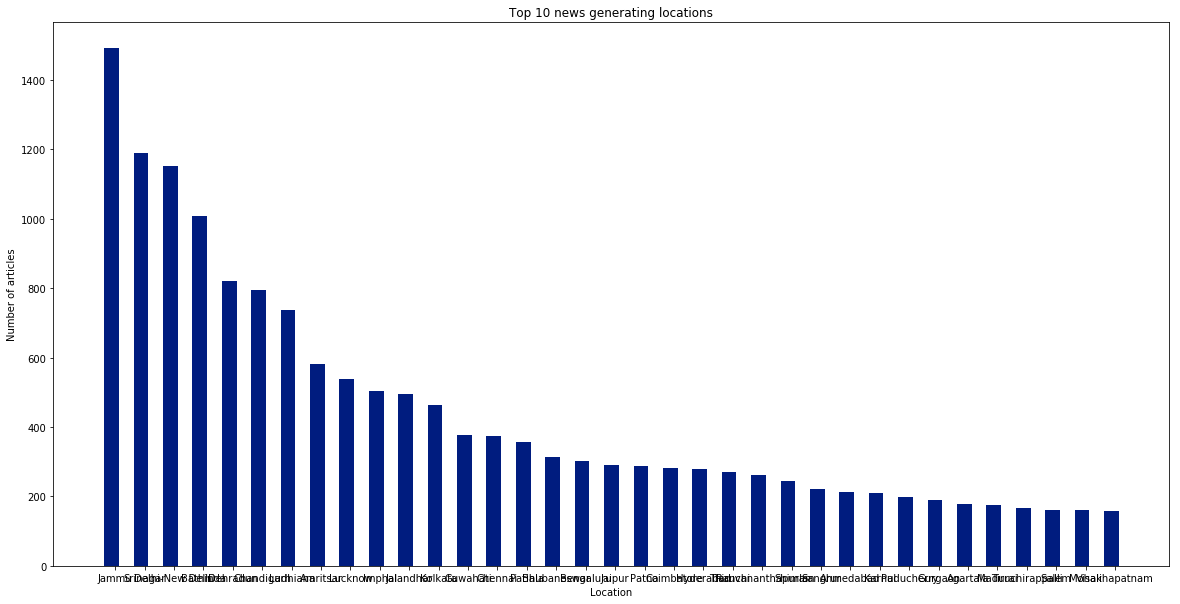

In [594]:
counter = Counter(df.location)
counter = sorted(counter.items(), key=lambda x: -x[1])[:35]
counter = np.array(counter)

places, counts = counter[:, 0].tolist(), counter[:, 1].astype(np.float32)
indices = np.arange(len(counts))
width = 1

plt.xlabel("Location")
plt.ylabel("Number of articles")
plt.interactive(True)

plt.xticks(indices + 0.125, places)
plt.title("Top 10 news generating locations")
_ = plt.bar(indices, counts, 0.5)

In [595]:
df['event_date'] = pd.to_datetime(df['event_date'])
df.sort_values(by=['event_date'], inplace=True)

In [596]:
dates = pd.date_range(start=df.iloc[0]['event_date'], end=df.iloc[-1]['event_date'])
print("Number of days -", len(dates))

Number of days - 1136


In [597]:
dates[0], dates[-1]

(Timestamp('2016-01-01 00:00:00', freq='D'),
 Timestamp('2019-02-09 00:00:00', freq='D'))

In [598]:
df = df[df['location'] == "Nagpur"]

num_events = np.zeros(len(dates))
i = 0
for date in dates:
    num_events[i] += len(df[df['event_date'] == date])
    i += 1

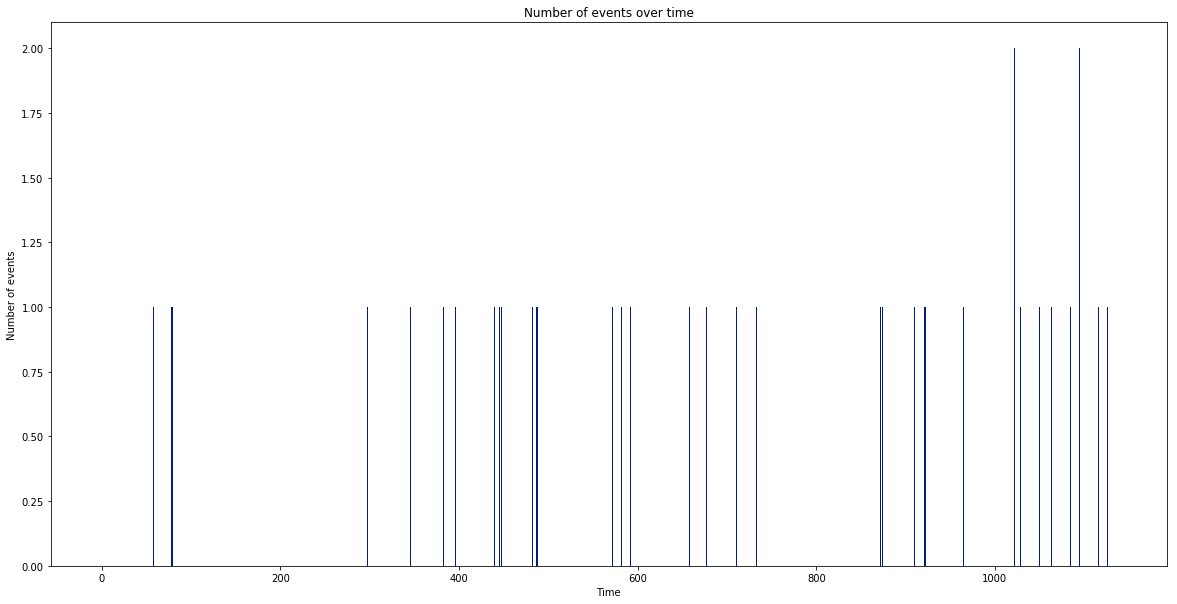

In [599]:
plt.title("Number of events over time")
plt.xlabel("Time")
plt.ylabel("Number of events")
_ = plt.bar(np.arange(len(num_events)), num_events)

In [600]:
news_articles = df.notes

In [601]:
def get_glove_dict():
    """
    Inputs - None
    
    Returns - Dict below
    
    Create a dict with word as key and word vector as value
    """
    d = {}
    f = open("../../glove_vectors/glove.6B.300d.txt", 'r')
    for row in f:
        row = row.replace('\n', '').split(" ")
        word = row[0]
        vector = np.array([float(x) for x in row[1:]])
        d[word] = vector
    f.close()
    return d

def generate_labels(num_events, num_days=2, days_window=2):
    """
    Inputs - 
        num_events - as generated as above 
        num_days - the number of days to after which we 
                   look for the occurence of an event.
                   Basically, the future
        day_window - If an event occurs in a window of days
                     after num_days
    
    Returns - Returns labels generated as below
    
    Generate labels by using the future events, basically
    look-ahead to create labels. If an event occurs from 
    i to i + num_days, then label is 1.0 else 0.0
    """
    n = len(num_events)
    labels = np.zeros(n - num_days - days_window)
    for i in range(n - num_days - days_window):
        labels[i] = 1.0 if sum(num_events[i + num_days: i + num_days + days_window] > 0) else 0.0
    return labels
    

In [602]:
if vector is None:
    vector = get_glove_dict()

In [603]:
num_days, days_window = 2, 5
labels = generate_labels(num_events, num_days, days_window)

In [604]:
print(labels.shape)

(1129,)


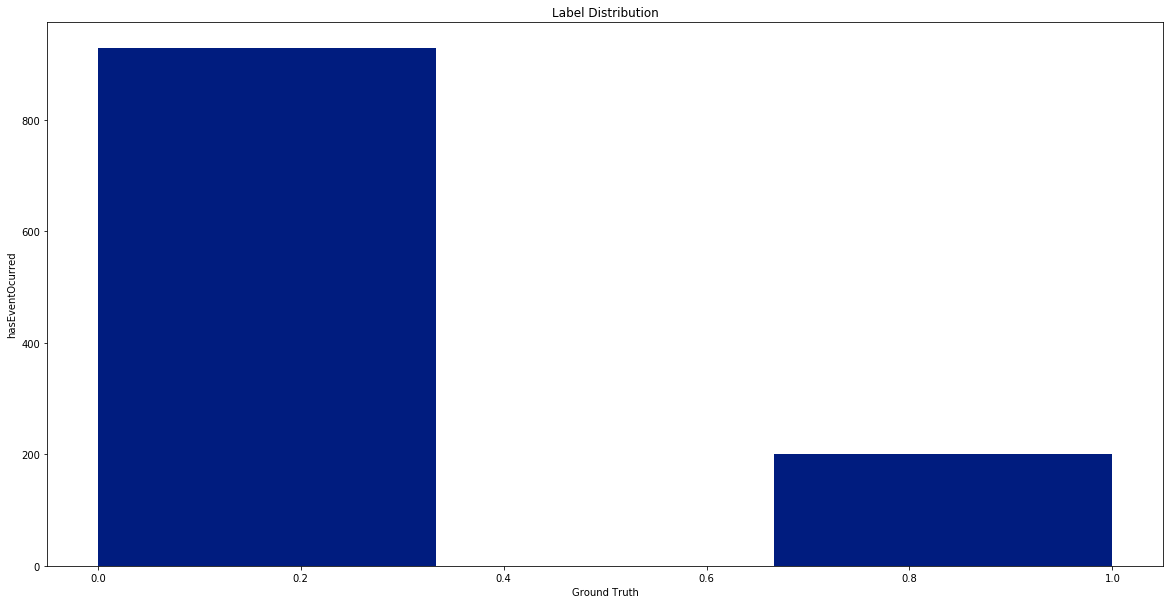

In [605]:
plt.title('Label Distribution')
plt.xlabel('Ground Truth')
plt.ylabel('hasEventOcurred')
_ = plt.hist(labels, bins=3, range=(0, 1))

In [544]:
# Tokenizer
nlp = spacy.load('en_core_web_sm')

# Generate sentence vectors
sentence_vectors = []
regexp = r'/[.,\/#!$%\^&\*;:{}=\-_`~()]/g'
num_sentences = len(news_articles)

for i, sentence in enumerate(news_articles):
    if i % 100 == 0:
        print (i, " / ", num_sentences, "done!")
    tokens = [t.text.lower() for t in nlp(sentence)]
    temp = []
    for token in tokens:
        vec = vector.get(token)
        if vec is None:
            vec = vector['unk']
        temp.append(vec)
    sentence_vectors.append(temp)
            

0  /  1492 done!
100  /  1492 done!
200  /  1492 done!
300  /  1492 done!
400  /  1492 done!
500  /  1492 done!
600  /  1492 done!
700  /  1492 done!
800  /  1492 done!
900  /  1492 done!
1000  /  1492 done!
1100  /  1492 done!
1200  /  1492 done!
1300  /  1492 done!
1400  /  1492 done!


In [545]:
# For the sentence vector, currently, simply just use average of all words vectors
for i, vecs in enumerate(sentence_vectors):
    sentence_vectors[i] = np.mean(vecs, axis=0)

In [546]:
sentence_vectors = np.array(sentence_vectors)
print("Sentence vector shape -", sentence_vectors.shape)

vector_dim = sentence_vectors.shape[-1]

Sentence vector shape - (1492, 300)


In [547]:
df.index = np.arange(len(df))
df.head(5)

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,actor1,assoc_actor_1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
0,2033551,356,IND57,57.0,2016-01-03,2016,1,Riots/Protests,Protesters (India),JKNPP: Jammu and Kashmir National Panthers Party,...,Jammu,32.7357,74.8691,1,Early Times (India),Subnational,"On Jan 03, activists of Jammu and Kashmir Nati...",0,1542756339,IND
1,2035847,356,IND85,85.0,2016-01-04,2016,1,Riots/Protests,Protesters (India),NSUI: National Students' Union of India,...,Jammu,32.7357,74.8691,1,Northlines,Subnational,"On Jan 04, the National Students Union of Indi...",0,1542756341,IND
2,2035765,356,IND84,84.0,2016-01-04,2016,1,Riots/Protests,Protesters (India),JWAM: Jammu West Assembly Movement,...,Jammu,32.7357,74.8691,1,Northlines,Subnational,"On Jan 04, an anti-Pakistan protest rally was ...",0,1542756341,IND
3,2010551,356,IND120,120.0,2016-01-05,2016,1,Riots/Protests,Protesters (India),Former Police Forces of India (2014-),...,Jammu,32.7357,74.8691,1,Northlines,Subnational,"On Jan 05, all J&K Retired Police Personnel Fo...",0,1542756306,IND
4,2016657,356,IND193,193.0,2016-01-08,2016,1,Riots/Protests,Protesters (India),Labour Group (India),...,Jammu,32.7357,74.8691,1,Early Times (India),Subnational,"On Jan 08, the Food & Allied workers Union Jam...",0,1542756322,IND


In [548]:
sentence_dict = {}
for date in dates:
    temp_df = df[df['event_date'] == date]
    
    if len(temp_df) == 0:
        sentence_dict[date] = (np.zeros(vector_dim))

    else:
        indices = list(temp_df.index)
        sentence_dict[date] = sentence_vectors[indices]

### Using average of averages

In [549]:
vec_date = []
for date in dates:
    arr = sentence_dict[date].reshape(-1, vector_dim)
    vec_date.append(np.mean(arr, axis=0))

In [550]:
history = 5
n = len(dates)

In [551]:
x, y = [], []
for i in range(history, n - num_days - days_window):
    x.append(vec_date[i - history: i])
    y.append(labels[i])

In [552]:
x, y = np.array(x), np.array(y)
# p = np.random.permutation(len(x))
# x, y = x[p], y[p]

In [553]:
print(x.shape, y.shape)

(1124, 5, 300) (1124,)


In [554]:
split = int(len(x) * 0.8)
xtrain, xtest = x[:split], x[split:]
ytrain, ytest = y[:split], y[split:]
ytrain, ytest = to_categorical(ytrain), to_categorical(ytest)

In [555]:
model = M.Sequential()
model.add(L.LSTM(30, return_sequences=True, input_shape=(history, vector_dim)))# , kernel_size=3))
model.add(L.LeakyReLU())
model.add(L.Dropout(0.2))

model.add(L.LSTM(15, input_shape=(history, vector_dim)))# , kernel_size=3))
model.add(L.LeakyReLU())
model.add(L.Dropout(0.2))

# model.add(L.GlobalMaxPool1D())

model.add(L.Dense(10))

model.add(L.Dense(2, activation='softmax'))

opzr = opt.Adam(0.001)
model.compile(opzr, loss=losses.binary_crossentropy, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23_input (InputLayer)   (None, 5, 300)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 5, 30)             39720     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 5, 30)             0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 5, 30)             0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 15)                2760      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 15)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 15)                0         
__________

In [556]:
print('Train shape -', xtrain.shape)
print('Test shape -', xtest.shape)

Train shape - (899, 5, 300)
Test shape - (225, 5, 300)


In [557]:
model.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=32, epochs=40)

Train on 899 samples, validate on 225 samples
Epoch 1/40
899/899 [==============================] - 5s 6ms/step - loss: 0.3887 - acc: 0.9466 - val_loss: 0.0325 - val_acc: 1.0000
Epoch 2/40
899/899 [==============================] - 0s 425us/step - loss: 0.1838 - acc: 0.9555 - val_loss: 0.0155 - val_acc: 1.0000
Epoch 3/40
899/899 [==============================] - 0s 425us/step - loss: 0.1771 - acc: 0.9555 - val_loss: 0.0174 - val_acc: 1.0000
Epoch 4/40
899/899 [==============================] - 0s 420us/step - loss: 0.1803 - acc: 0.9555 - val_loss: 0.0211 - val_acc: 1.0000
Epoch 5/40
899/899 [==============================] - 0s 421us/step - loss: 0.1729 - acc: 0.9555 - val_loss: 0.0208 - val_acc: 1.0000
Epoch 6/40
899/899 [==============================] - 0s 410us/step - loss: 0.1729 - acc: 0.9555 - val_loss: 0.0201 - val_acc: 1.0000
Epoch 7/40
899/899 [==============================] - 0s 379us/step - loss: 0.1640 - acc: 0.9555 - val_loss: 0.0236 - val_acc: 1.0000
Epoch 8/40
899/899

In [563]:
pred = model.predict(xtest)
if len(pred.shape) == 1:
    ytest_ = ytest
else:
    pred = model.predict_proba(xtest) [:, 1]
    threshold = 0.68
    pred[pred > threshold] = 1
    pred[pred <= threshold] = 0
    ytest_ = np.argmax(ytest, axis=1)

In [564]:
print(metrics.classification_report(ytest_, pred))

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         0
        1.0       1.00      0.96      0.98       225

avg / total       1.00      0.96      0.98       225



/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [565]:
conf_mat = metrics.confusion_matrix(ytest_, pred)
# conf_mat = conf_mat * 100. / np.sum(conf_mat, axis=1, keepdims=True)


In [566]:
conf_mat

array([[  0,   0],
       [  9, 216]])

### Using news articles as such

In [36]:
history = 5
n = len(dates)

In [37]:
x, y = [], []
for date in dates:
    sentence_vecs = sentence_dict[date]
    